# Spotify Genre Prediction

### 1. Preprocesamiento y Transformación

- Importar librerías

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

- Importar CSV

In [54]:
df = pd.read_csv('train.csv')

- Eliminar columnas irrelevantes

In [55]:
columns_to_drop = ['type', 'id', 'uri', 'track_href', 'analysis_url', 'genre', 'song_name', 'title', 'Unnamed: 0', 'Id']

df_cleaned = df.drop(columns=columns_to_drop, errors='ignore')  # errors='ignore' evita fallos si no existen

- Normalizar datos

In [56]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)

- Guardar dataset limpio

In [57]:
df_scaled.to_csv("train_clean.csv", index=False)
df_scaled.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1.640192,-0.392062,-1.197591,-0.319946,0.906382,1.839910,-0.491316,-0.767334,-0.715319,1.317208,1.781719,-0.957013,0.100091
1,-1.328201,1.085896,-0.924416,0.217197,0.906382,-0.051699,-0.549142,-0.331527,2.360748,-0.998500,-0.394293,-0.311599,0.100091
2,0.296738,-0.386609,-1.470766,0.306550,-1.103287,1.475835,2.263485,-0.767334,-0.257060,1.248721,1.106304,0.174947,-3.630617
3,-1.270624,0.698682,0.441460,1.230888,-1.103287,-0.787765,-0.456749,1.425152,-0.171882,-1.378173,1.157778,0.663642,0.100091
4,-1.686455,0.616876,-0.378065,1.291826,-1.103287,-0.281225,-0.358321,-0.767334,-0.506916,-0.459167,2.293609,-0.279109,0.100091


### 2. Diseño, Entrenamiento y Evaluación del Modelo

In [58]:
X_scaled = pd.read_csv("train_clean.csv")

####  Aplicar K-Means

- Número óptimo de clusters usando el método del codo

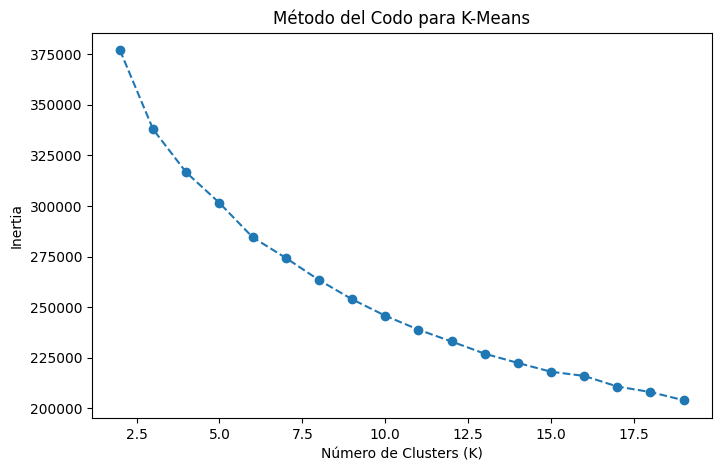

In [ ]:
# Elegir el número óptimo de clusters usando el método del codo
inertia = []
K_range = range(2, 20)  # Probar de 2 a 20 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Graficar Elbow Method
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker="o", linestyle="--")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Inertia")
plt.title("Método del Codo para K-Means")
plt.show()

- Aplicar K-Means con el mejor K

Silhouette Score para K-Means: 0.1176


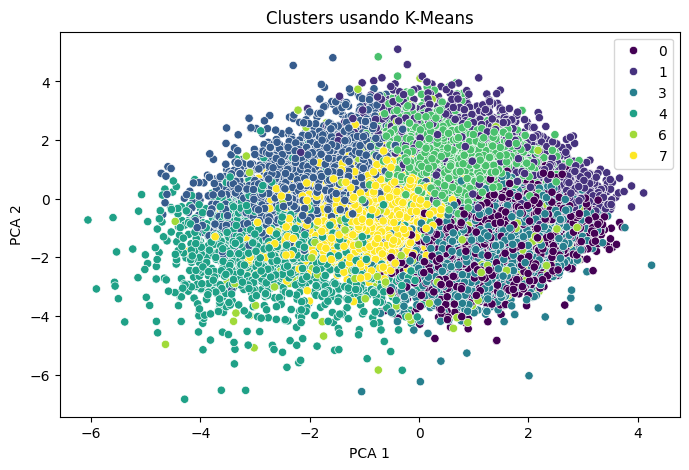

In [64]:
best_k = 8
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_scaled)

# Evaluación con Silhouette Score
silhouette_kmeans = silhouette_score(X_scaled, clusters_kmeans)
print(f"Silhouette Score para K-Means: {silhouette_kmeans:.4f}")

# Visualización en 2D con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters_kmeans, palette="viridis")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Clusters usando K-Means")
plt.show()

#### Aplicar DBSCAN

DBSCAN encontró 38 clusters
Silhouette Score para DBSCAN: -0.1580


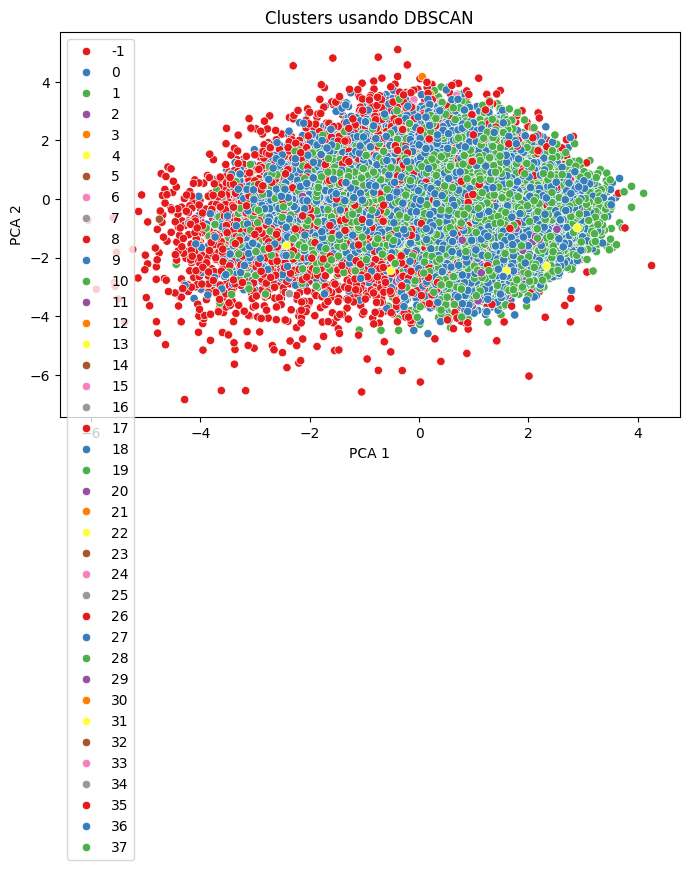

In [61]:
# Ajustar DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)  # Ajustar eps según los datos
clusters_dbscan = dbscan.fit_predict(X_scaled)

# Evaluar número de clusters encontrados
n_clusters_dbscan = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
print(f"DBSCAN encontró {n_clusters_dbscan} clusters")

# Evaluar con Silhouette Score (si hay más de 1 cluster válido)
if n_clusters_dbscan > 1:
    silhouette_dbscan = silhouette_score(X_scaled, clusters_dbscan)
    print(f"Silhouette Score para DBSCAN: {silhouette_dbscan:.4f}")

# Visualización en 2D con PCA
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters_dbscan, palette="Set1")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Clusters usando DBSCAN")
plt.show()

### 3. Resultados y conclusiones